In [ ]:
# import numpy as np
# from scipy.interpolate import RegularGridInterpolator
# from configure import *
# import time
# from concurrent.futures import ProcessPoolExecutor
# import psutil

# dirname = os.getcwd()
# flag_smoothing=True #是否对导入的电势场格点数据做平滑化，如果True，那么平滑化函数默认按照下文def smoothing(data)
# filename=os.path.join(dirname, "../../../data/monolithic20241118.csv") #文件名：导入的电势场格点数据
# basis_filename=os.path.join(dirname, "electrode_basis.json")#文件名：自定义Basis设置 #可以理解为一种基矢变换，比如"U1"相当于电势场组合"esbe1"*0.5+"esbe1asy"*-0.5
# basis = Data_Loader(filename, basis_filename, flag_smoothing)
# basis.loadData()
# configure = Configure(basis=basis)
# dl = configure.dl
# dt = configure.dt
# dV = configure.dV
# # configure.load_from_file(os.path.join(dirname, "../saves/saved_config_regression_0.01_1000.json"))
# configure.load_from_file(os.path.join(dirname, "../saves/flat_28.json"))
# Vs = configure.static_potential()
# Vpp = configure.pseudo_potential()
# Vt = Vs + Vpp

# N = 10000

# grid_x, grid_y, grid_z = basis.coordinate_um
# print("Vt shape:", Vt.shape)
# Vt_itp = RegularGridInterpolator((grid_x, grid_y, grid_z), Vt, method="linear", bounds_error=True)

# def Energy(r):
#     N = r.shape[0]
#     Vt_min = np.min(Vt_itp(r))
#     return sum(Vt_itp(r)-Vt_min)

# def Hessian_i(i, N, DIM, r1, Er, h=0.1):
#     res = np.zeros(N*DIM)
#     for j in range(N*DIM):
#         if i == j:
#             r_ip = r_im = r1
#             r_ip[i] += h
#             r_im[i] -= h
#             res[j] = (Energy(r_ip.reshape(N,DIM))-2*Er+Energy(r_im.reshape(N,DIM)))/h**2
#         else:
#             r_ip_jp = r_ip_jm = r_im_jp = r_im_jm = r1
#             r_ip_jp[i] += h
#             r_ip_jp[j] += h
#             r_ip_jm[i] += h
#             r_ip_jm[j] -= h
#             r_im_jp[i] -= h
#             r_im_jp[j] += h
#             r_im_jm[i] -= h
#             r_im_jm[j] -= h
#             res[j] = (Energy(r_ip_jp.reshape(N,DIM))-Energy(r_ip_jm.reshape(N,DIM))-Energy(r_im_jp.reshape(N,DIM))+Energy(r_im_jm.reshape(N,DIM)))/(4*h**2)
#     return i, res

# def Hessian_ij(i, j, N, DIM, r1, Er, h=0.1):
#     if i == j:
#         r_ip = r_im = r1
#         r_ip[i] += h
#         r_im[i] -= h
#         return (Energy(r_ip.reshape(N,DIM))-2*Er+Energy(r_im.reshape(N,DIM)))/h**2
#     else:
#         r_ip_jp = r_ip_jm = r_im_jp = r_im_jm = r1
#         r_ip_jp[i] += h
#         r_ip_jp[j] += h
#         r_ip_jm[i] += h
#         r_ip_jm[j] -= h
#         r_im_jp[i] -= h
#         r_im_jp[j] += h
#         r_im_jm[i] -= h
#         r_im_jm[j] -= h
#         return i, j, (Energy(r_ip_jp.reshape(N,DIM))-Energy(r_ip_jm.reshape(N,DIM))-Energy(r_im_jp.reshape(N,DIM))+Energy(r_im_jm.reshape(N,DIM)))/(4*h**2)

# def Hessian(r, h=0.1):
#     N, DIM = r.shape
#     H = np.zeros((N*DIM, N*DIM))
#     Er = Energy(r)
#     r1 = r.ravel()
#     with ProcessPoolExecutor() as executor:
#         max_workers = executor._max_workers
#         print(f"最大并行进程数: {max_workers}")
#         Futures = [executor.submit(Hessian_i, i, N, DIM, r1, Er, h) for i in range(N*DIM)]
#         parent = psutil.Process()  # 当前 Python 进程
#         children = parent.children(recursive=True)  # 获取所有子进程
#         print(f"当前运行的子进程数 by psutil: {len(children)}")
#         time.sleep(0.1)  # 短暂等待以确保子进程启动
#         active_processes = len(multiprocessing.active_children())
#         print(f"当前活跃进程数 by multiprocessing: {active_processes}")
#         for f in Futures:
#             i, Hi = f.result()
#             H[i] = Hi
#     np.save("../data_cache/%d/Hessian/flat_28_100us.npy"%N)
#     return H

# r = np.load("../data_cache/%d/ion_pos/100us.npy"%N)
# start = time.time()
# H = Hessian(r)
# end = time.time()
# print("Total time spent: ", end-start, "s")

dl: 2.7437758083117576e-07 m
dt: 9.022389064166401e-09 s
dV: 0.001312028248176 V
Loaded custom basis: {'RF': 'esbe', 'U1': 'esbe1', 'U2': 'esbe2', 'U3': 'esbe3', 'U4': 'esbe4', 'U5': 'esbe5', 'U6': 'esbe6', 'U7': 'esbe7'}
加载自定义Basis设置
self.unit_l= 0.001
Vt shape: (101, 51, 201)
最大并行进程数: 208
当前运行的子进程数 by psutil: 208
当前活跃进程数 by multiprocessing: 208


In [ ]:
# 4th-order poly fit

import numpy as np
from scipy.interpolate import RegularGridInterpolator
from configure import *
import time
from concurrent.futures import ProcessPoolExecutor
import psutil
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score


dirname = os.getcwd()
flag_smoothing=True #是否对导入的电势场格点数据做平滑化，如果True，那么平滑化函数默认按照下文def smoothing(data)
filename=os.path.join(dirname, "../../../data/monolithic20241118.csv") #文件名：导入的电势场格点数据
basis_filename=os.path.join(dirname, "electrode_basis.json")#文件名：自定义Basis设置 #可以理解为一种基矢变换，比如"U1"相当于电势场组合"esbe1"*0.5+"esbe1asy"*-0.5
basis = Data_Loader(filename, basis_filename, flag_smoothing)
basis.loadData()
configure = Configure(basis=basis)
# configure.load_from_file(os.path.join(dirname, "../saves/saved_config_regression_0.01_1000.json"))
configure.load_from_file(os.path.join(dirname, "../saves/flat_28.json"))
Vs = configure.static_potential()
Vpp = configure.pseudo_potential()
Vt = Vs + Vpp

print(Vt.shape)
Vt -= np.min(Vt)

grid_x, grid_y, grid_z = basis.coordinate_um
Vt_ravel = Vt.ravel()

X, Y, Z = np.meshgrid(grid_x, grid_y, grid_z, indexing='ij')
grid = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1)

model = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=4, include_bias=True),  # 自动生成 x^i y^j z^k (i+j+k<=4)
    LinearRegression(fit_intercept=False)            # 已经包含常数项
)
model.fit(grid, Vt_ravel)

# 预测
f_pred = model.predict(grid)

# 获取系数（35 个，按 PolynomialFeatures 的顺序）
coef = model.named_steps['linearregression'].coef_
print("系数数量:", len(coef))  # → 35
poly = model.named_steps['polynomialfeatures']
feature_names = poly.get_feature_names_out(['x', 'y', 'z'])
for name, c in zip(feature_names, coef):
    print(f"{name}: {c:.6g}")

print("RMSE:", np.sqrt(mean_squared_error(Vt_ravel, f_pred)))
print("R²:", r2_score(Vt_ravel, f_pred))

Loaded custom basis: {'RF': 'esbe', 'U1': 'esbe1', 'U2': 'esbe2', 'U3': 'esbe3', 'U4': 'esbe4', 'U5': 'esbe5', 'U6': 'esbe6', 'U7': 'esbe7'}
加载自定义Basis设置
self.unit_l= 0.001
(101, 51, 201)
系数数量: 35
1: 0.0021835
x: -0.000523116
y: 0.0002584
z: 0.000393049
x^2: -0.00165117
x y: -0.000214916
x z: 0.000309627
y^2: 0.118421
y z: 0.000670278
z^2: -0.00662347
x^3: 0.000154883
x^2 y: 4.44245e-05
x^2 z: 4.69371e-05
x y^2: 0.000383497
x y z: 7.98947e-06
x z^2: 0.000227749
y^3: -8.16372e-05
y^2 z: -4.07413e-05
y z^2: -0.000223191
z^3: -0.000126166
x^4: 0.0331962
x^3 y: 2.90375e-05
x^3 z: -0.000114844
x^2 y^2: 0.00693812
x^2 y z: 2.94234e-05
x^2 z^2: 0.00224849
x y^3: 0.000115836
x y^2 z: 0.00020085
x y z^2: 4.50632e-05
x z^3: -0.000173463
y^4: -0.00312395
y^3 z: -0.000328479
y^2 z^2: 0.000182803
y z^3: -0.000142323
z^4: 0.00497955
RMSE: 0.0029975224728808606
R²: 0.9995161364260279


In [28]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
import sympy as sp
from scipy.linalg import block_diag
from scipy.constants import e

# 取出系数和指数
poly = model.named_steps['polynomialfeatures']
coef = model.named_steps['linearregression'].coef_     # 标准化坐标下的系数
powers = poly.powers_                                  # (35, 3) 每行 [i,j,k]

mean = model.named_steps['standardscaler'].mean_
std  = model.named_steps['standardscaler'].scale_

# 变量（标准化坐标）
xs, ys, zs = sp.symbols('xs ys zs')   # 标准化后的变量

# 构建 p(xs,ys,zs)
p = sum(c * xs**i * ys**j * zs**k for c,(i,j,k) in zip(coef, powers))

# 解析求二阶偏导（Hessian）
H11 = sp.diff(p, xs, 2)
H12 = sp.diff(p, xs, ys)
H13 = sp.diff(p, xs, zs)
H22 = sp.diff(p, ys, 2)
H23 = sp.diff(p, ys, zs)
H33 = sp.diff(p, zs, 2)

# 转成 numpy 可快速计算的函数（超级快！）
H_funcs = [sp.lambdify((xs,ys,zs), h, 'numpy') for h in [H11,H12,H13,H22,H23,H33]]

def hessian_exact(xyz_orig):
    """
    输入原始物理坐标 (M,3)，返回 (M,3,3) 的 Hessian
    """
    xyz_scaled = (xyz_orig - mean) / std        # 关键：转成标准化坐标
    xs, ys, zs = xyz_scaled[:,0], xyz_scaled[:,1], xyz_scaled[:,2]
    H = np.zeros((len(xyz_orig), 3, 3))
    H[:,0,0] = H_funcs[0](xs,ys,zs)
    H[:,0,1] = H[:,1,0] = H_funcs[1](xs,ys,zs)
    H[:,0,2] = H[:,2,0] = H_funcs[2](xs,ys,zs)
    H[:,1,1] = H_funcs[3](xs,ys,zs)
    H[:,1,2] = H[:,2,1] = H_funcs[4](xs,ys,zs)
    H[:,2,2] = H_funcs[5](xs,ys,zs)

    inv_std = 1.0 / std  # [1/sx, 1/sy, 1/sz]

    H_x = np.zeros_like(H)
    for i in range(3):
        for j in range(3):
            H_x[:, i, j] = H[:, i, j] * inv_std[i] * inv_std[j]
    return H
N = 10000
r = np.load("../data_cache/%d/ion_pos/100us.npy"%N)
start = time.time()
Hf = hessian_exact(r*1e-6)  #SI
end = time.time()
print(Hf[0])      # 第一个点的 Hessian 矩阵（解析精确）
print("Total time spent: ", end-start, "s")
Hf = block_diag(*Hf)    # * stands for variable num of paras
print(Hf.shape)
print(Hf[0:6,0:6])

[[-3.30233811e-03 -2.14916434e-04  3.09626731e-04]
 [-2.14916434e-04  2.36842707e-01  6.70278864e-04]
 [ 3.09626731e-04  6.70278864e-04 -1.32469425e-02]]
Total time spent:  0.03377723693847656 s
(30000, 30000)
[[-3.30233811e-03 -2.14916434e-04  3.09626731e-04  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-2.14916434e-04  2.36842707e-01  6.70278864e-04  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 3.09626731e-04  6.70278864e-04 -1.32469425e-02  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.30233827e-03
  -2.14916457e-04  3.09626916e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.14916457e-04
   2.36842707e-01  6.70278663e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.09626916e-04
   6.70278663e-04 -1.32469430e-02]]


(101, 201)
(101, 201)


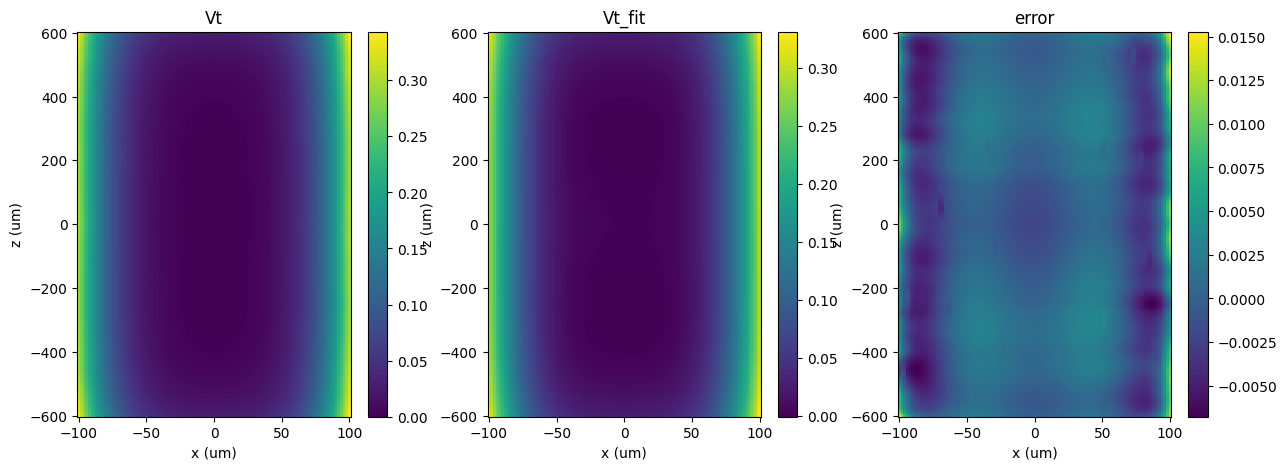

In [20]:
import matplotlib.pyplot as plt
Vt_raw = Vt[:, np.floor(Vt.shape[1]/2).astype(int), :]
xg, yg, zg = basis.coordinate_um
# xg = (xg-xg.mean())/xg.std()
# yg = (yg-yg.mean())/yg.std()
# zg = (zg-zg.mean())/zg.std()
X, Z = np.meshgrid(xg, zg, indexing='ij')   # X,Z 形状都是 (Nx, Nz)
y0 =yg[np.floor(len(yg)/2).astype(int)]  # 固定 y0

# 构造输入点 (Nx*Nz, 3)
points = np.stack([
    X.ravel(),                   # x 坐标
    np.full_like(X, y0).ravel(), # 固定的 y0
    Z.ravel()                    # z 坐标
], axis=1)                       # (Nx*Nz, 3)

# 预测并 reshape 回平面
Vt_fit = model.predict(points).reshape(X.shape)  # 形状 (Nx, Nz)

print(Vt_raw.shape)  # (Nx, Nz)
print(Vt_fit.shape)  # (Nx, Nz)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
im0 = ax[0].pcolormesh(xg, zg, Vt_raw.T)
ax[0].set_title('Vt')
ax[0].set_xlabel('x (um)')
ax[0].set_ylabel('z (um)')
fig.colorbar(im0, ax=ax[0])
im1 = ax[1].pcolormesh(xg, zg, Vt_fit.T)
ax[1].set_title('Vt_fit')
fig.colorbar(im1, ax=ax[1])
ax[1].set_xlabel('x (um)')
ax[1].set_ylabel('z (um)')
im2 = ax[2].pcolormesh(xg, zg, Vt_raw.T-Vt_fit.T)
ax[2].set_title('error')
fig.colorbar(im2, ax=ax[2])
ax[2].set_xlabel('x (um)')
ax[2].set_ylabel('z (um)')
plt.show()

In [ ]:
# import os, subprocess, sys

# def build_and_load_hessian():
#     cmd = """
#     cd /root/ylc/cuda_acc_v2/src/coulomb_hessian_cuda/build && 
#     rm -rf * && 
#     cmake .. -DCMAKE_BUILD_TYPE=Release && 
#     cmake --build . -j && 
#     cp coulomb_hessian*.so . 2>/dev/null || 
#     cp coulomb_hessian*.so /tmp/
#     """
#     print("正在编译...")
#     result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
#     print(result.stdout)
#     if result.returncode == 0:
#         sys.path.append(".")      # 当前目录
#         sys.path.append("/tmp")   # 备用
#         import importlib, coulomb_hessian
#         importlib.reload(coulomb_hessian)  # 强制重新加载
#         print("coulomb_hessian 加载成功！")
#         return coulomb_hessian
#     else:
#         print("编译失败", result.stderr)

# ch = build_and_load_hessian()

正在编译...
-- The CXX compiler identification is GNU 11.3.0
-- The CUDA compiler identification is NVIDIA 11.8.89
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Detecting CUDA compiler ABI info
-- Detecting CUDA compiler ABI info - done
-- Check for working CUDA compiler: /usr/local/cuda-11.8/bin/nvcc - skipped
-- Detecting CUDA compile features
-- Detecting CUDA compile features - done
-- pybind11 v2.14.0 dev1
-- Found PythonInterp: /root/anaconda3/envs/ism_ylc/bin/python (found suitable version "3.11.13", minimum required is "3.8") 
-- Found PythonLibs: /root/anaconda3/envs/ism_ylc/lib/libpython3.11.so
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- Configuring done
-- Generating done
-- Build files have been written to: /root/ylc/cuda_acc_v2/src/coulomb_hessian_cuda/build
[ 33%] Building CXX object CMa

In [ ]:
# CUDA Parellel in Hc
# import numpy as np
# from coulomb_hessian import hessian

# N = 2000
# pos = np.random.rand((3*N))
# # pos = np.load("../data_cache/%d/ion_pos/100us.npy"%N).ravel()
# charges = np.ones(N)

# Hc = hessian(pos, charges)          # 默认 prefactor=1.0
# print(Hc.shape)    # (6144, 6144)
# print(np.max(Hc), np.min(Hc), np.mean(np.abs(Hc)))
# print(np.linalg.norm(Hc - Hc.T))  # ≈0，对称性验证

(6000, 6000)
0.0 0.0 0.0
0.0


In [25]:
# CPU Parallel in Hc

from concurrent.futures import ProcessPoolExecutor
from numpy.linalg import norm, eigvalsh
import time
import numpy as np

def hessian_i(i, R):
    start_i = time.time()
    res = np.zeros((3, 3*N))
    for j in range(N):
        if i == j:
            continue
        else:
            rij = R[i] - R[j]
            r = norm(rij) + 1e-20
            outer = np.outer(rij, rij)
            block = np.eye(3)/(r**3) - 3*outer/(r**5)
            # 对称填充 Hessian
            res[:, 3*j:3*j+3] = block
    res[:, 3*i:3*i+3] = -sum(res[:, 3*j:3*j+3] for j in range(N))
    end_i = time.time()
    print("Finished %d, taking %.3f s"%(i, end_i-start_i))
    return i, res

def hessian_parallel(R):
    R = R.reshape(N, 3)
    H = np.zeros((3*N, 3*N))
    with ProcessPoolExecutor(max_workers=12) as executor:
        futures = [executor.submit(hessian_i, i, R) for i in range(N)]
        for future in futures:
            i, res = future.result()
            H[3*i:3*i+3, :] = res
    return H*e**2/(4*pi*epsilon_0)

if __name__ == "__main__":
    N = 10000
    r = np.load("../data_cache/%d/ion_pos/100us.npy"%N)
    start = time.time()
    Hc = hessian_parallel(r*1e-6)  # SI
    # np.save("../data_cache/%d/hessian_coulomb.npy"%N, Hc)
    end = time.time()
    print(end-start)

Finished 8, taking 0.084 sFinished 9, taking 0.083 s

Finished 3, taking 0.123 s
Finished 4, taking 0.137 sFinished 2, taking 0.140 s


Finished 0, taking 0.147 sFinished 11, taking 0.128 s
Finished 5, taking 0.148 s
Finished 7, taking 0.137 sFinished 1, taking 0.152 s

Finished 10, taking 0.136 s
Finished 6, taking 0.148 s
Finished 12, taking 0.083 s
Finished 14, taking 0.111 s
Finished 15, taking 0.122 s
Finished 13, taking 0.159 s
Finished 16, taking 0.161 s
Finished 17, taking 0.160 sFinished 18, taking 0.155 s

Finished 20, taking 0.150 s
Finished 19, taking 0.163 s
Finished 25, taking 0.083 s
Finished 21, taking 0.165 s
Finished 22, taking 0.162 s
Finished 26, taking 0.083 sFinished 24, taking 0.154 s

Finished 23, taking 0.162 s
Finished 27, taking 0.103 s
Finished 33, taking 0.084 s
Finished 29, taking 0.110 s
Finished 36, taking 0.083 s
Finished 28, taking 0.125 s
Finished 31, taking 0.113 s
Finished 30, taking 0.125 s
Finished 32, taking 0.117 s
Finished 37, taking 0.104 s
Fi

In [26]:
print(np.max(Hf), np.min(Hf), np.mean(np.abs(Hf)))
print(np.max(Hc), np.min(Hc), np.mean(np.abs(Hc)))
H = Hf + Hc
print(np.min(H), np.max(H), np.mean(np.abs(H)))
np.save("../data_cache/%d/hessian.npy"%N, H)

3.7946385300433784e-20 -2.1223944880544243e-21 4.553415057252004e-25
1.7780061991651102e-10 -1.7809764642250833e-10 8.224033200795452e-15
-1.7809764638456194e-10 1.7780061991438863e-10 8.224033200344054e-15


In [3]:
import numpy as np
Hessian_matrix = np.load("../data_cache/%d/hessian.npy"%10000)
Hessian_y = np.zeros((10000, 10000))
Hessian_y = Hessian_matrix[1::3, 1::3]
np.save("../data_cache/%d/hessian_y.npy"%10000, Hessian_y)
print(Hessian_matrix)
print(Hessian_y)

[[ 1.26042934e-15 -6.73814353e-18  6.28677860e-17 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-6.73814353e-18  6.13164801e-15  1.77309473e-17 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 6.28677860e-17  1.77309473e-17  1.33567134e-15 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  5.22224940e-17
  -4.90364361e-18 -6.09897539e-19]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.90364361e-18
   6.09000641e-15  1.82940517e-17]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -6.09897539e-19
   1.82940517e-17  9.88009320e-16]]
[[6.13164801e-15 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 6.18705772e-15 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 6.09861344e-15 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 6.09814932e

In [ ]:
eigenvalues, eigenvectors = np.linalg.eigh(H)